In [1]:
import os
import keras
import random
import numpy as np
import pandas as pd
import tensorflow as tf

from scipy.spatial.distance import cosine
from itertools import combinations

from PIL import Image

In [2]:
from itertools import combinations, product
from sklearn.metrics.pairwise import cosine_similarity

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

In [3]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

In [4]:
model = keras.models.load_model('ghostfacenet_v1.h5')

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [5]:
dataset_dir = 'dataset'
persons = os.listdir(dataset_dir)

In [6]:
persons = [p for p in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, p)) and not p.startswith('.')]
random.shuffle(persons) 

# Split into enrolled and unenrolled
enrolled_persons = persons[:1500]
unenrolled_persons = persons[1500:]

data = []

for person in enrolled_persons:
    person_dir = os.path.join(dataset_dir, person)
    images = os.listdir(person_dir)
    selected_images = random.sample(images, 3) if len(images) >= 3 else images  
    for image in selected_images:
        data.append([person, os.path.join(person_dir, image), 'Enrolled'])

for person in unenrolled_persons:
    person_dir = os.path.join(dataset_dir, person)
    images = os.listdir(person_dir)
    if images:  # Ensure there is at least one image
        selected_image = random.choice(images)
        data.append([person, os.path.join(person_dir, selected_image), 'Not Enrolled'])

In [7]:
df = pd.DataFrame(data, columns=['Person', 'Image_Path', 'Label'])
print(len(df))  

5000


In [8]:
df.head()

,Person,Image_Path,Label
0,1593,dataset/1593/24.png,Enrolled
1,1593,dataset/1593/37.png,Enrolled
2,1593,dataset/1593/9.png,Enrolled
3,170,dataset/170/56.png,Enrolled
4,170,dataset/170/69.png,Enrolled


In [9]:
random.shuffle(persons)  # Shuffle to randomize the persons selected

# Split into enrolled and unenrolled
enrolled_persons = persons[:1500]
unenrolled_persons = persons[1500:]

# Selecting genuine probes: 3 images from each enrolled person
genuine_probes = []
for person in enrolled_persons:
    if person[0] == '.':
        continue
    person_dir = os.path.join(dataset_dir, person)
    images = os.listdir(person_dir)
    genuine_probes.extend(random.sample(images, 3))

# Selecting impostor probes: 1 image from each unenrolled person
impostor_probes = []
for person in unenrolled_persons[:500]:
    if person[0] == '.':
        continue
    person_dir = os.path.join(dataset_dir, person)
    images = os.listdir(person_dir)
    impostor_probes.append(random.choice(images))

In [10]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, train_size= 0.7, shuffle= True, random_state= RANDOM_SEED)

In [11]:
print(len(test_df))

1500


---------  above ok --------------

In [17]:
def generate_pairs(df):
    """Generate all possible genuine and impostor pairs and then randomly select impostor pairs to match the number of genuine pairs."""
    genuine_pairs = []
    impostor_pairs = []

    # Generate genuine pairs
    for _, group in df.groupby('Person'):
        genuine_pairs.extend(list(combinations(group['Image_Path'], 2)))

    # Compute all possible impostor pairs
    temp_impostor_pairs = []
    unique_person_ids = df['Person'].unique()
    for person_id_a, person_id_b in combinations(unique_person_ids, 2):
        paths_a = df[df['Person'] == person_id_a]['Image_Path']
        paths_b = df[df['Person'] == person_id_b]['Image_Path']
        temp_impostor_pairs.extend(product(paths_a, paths_b))
    
    # Randomly select impostor pairs to match the number of genuine pairs
    if len(temp_impostor_pairs) > len(genuine_pairs):
        impostor_pairs = random.sample(temp_impostor_pairs, len(genuine_pairs))
    else:
        impostor_pairs = temp_impostor_pairs

    return genuine_pairs, impostor_pairs


In [18]:
genuine_pairs, impostor_pairs = generate_pairs(test_df)


In [19]:
print(len(genuine_pairs))

399


In [20]:
print(len(impostor_pairs))

399


In [30]:
def get_embedding(model, image_path):
    """
    Get an image embedding using ghostfacenet_v1 model.
    
    Parameters:
    - image_path: Path to the image file.
    
    Returns:
    - embedding: The embedding vector for the image.
    """
    img = Image.open(image_path).convert('RGB')
    img = img.resize((112, 112))
    img_array = np.array(img).astype('float32')
    
    # Normalize the image data to [-1, 1]
    img_array = (img_array / 127.5) - 1  # Assuming the original range is [0, 255]
    return model.predict(np.expand_dims(img_array, axis=0))


def compute_cosine_distance(features1, features2):
    # Compute and return the cosine distance between two feature vectors
    return cosine_similarity(features1, features2)

def compute_distances(pairs, model):
    """Compute the cosine distance for each pair, handling NaN values."""
    distances = []
    for img_path_a, img_path_b in pairs:

        embedding1 = get_embedding(model, img_path_a)
        embedding2 = get_embedding(model, img_path_b)

        if embedding1 is None or embedding2 is None:
            print(f"Skipping pair {img_path_a}, {img_path_b} due to an error.")
            continue
        # Ensure no NaN values are present in features before computing distance
        if np.isnan(embedding1).any() or np.isnan(embedding2).any():
            print(f"Found NaN in features for pair {img_path_a}, {img_path_b}. Skipping.")
            continue
        # Compute cosine similarity and convert it to distance
        similarity = cosine_similarity(embedding1.reshape(1, -1), embedding2.reshape(1, -1))
        distance = 1 - similarity.item()  # Convert numpy array to scalar
        print(f"Distance between {img_path_a} and {img_path_b}: {distance}")
        distances.append(distance)
    return distances

In [ ]:
genuine_distances = compute_distances(genuine_pairs, model)

In [ ]:
impostor_distances = compute_distances(impostor_pairs, model)

In [33]:
print(impostor_distances)

[0.9558769166469574, 0.9852291811257601, 0.9834005311131477, 0.7727940827608109, 0.7179615497589111, 1.0199040621519089, 0.9931047074496746, 0.7742968201637268, 0.9266489595174789, 0.768708348274231, 0.8639180362224579, 1.0022139274515212, 0.8355524241924286, 0.7927316427230835, 0.7999085187911987, 1.001103295944631, 0.9486871361732483, 0.9697746187448502, 0.9775345176458359, 0.762077584862709, 0.8686010539531708, 0.9808289147913456, 0.7941057682037354, 0.9283743500709534, 0.8019586652517319, 0.7440077066421509, 0.8503034263849258, 0.8508463203907013, 0.9766532890498638, 0.9874053336679935, 0.8967286646366119, 0.9607216194272041, 1.000383984297514, 0.9753408804535866, 0.7390269637107849, 0.9195351973176003, 0.8813528046011925, 0.892404668033123, 0.6998376250267029, 0.922886461019516, 1.1308923214673996, 0.9062410295009613, 0.9972728565335274, 0.8640103489160538, 0.982693849131465, 1.0389345660805702, 0.8748224675655365, 1.0051909368485212, 0.896133154630661, 0.9052317664027214, 0.92383

In [34]:
def evaluate_threshold(distances, threshold):
    """Evaluate pairs against the threshold to determine matches and non-matches."""
    matches = [distance <= threshold for distance in distances]
    return matches

def calculate_metrics(genuine_distances, impostor_distances, threshold):
    """Calculate evaluation metrics based on distances and a threshold."""
    genuine_matches = evaluate_threshold(genuine_distances, threshold)
    impostor_matches = evaluate_threshold(impostor_distances, threshold)

    # True Positive: Genuine pair correctly matched
    tp = sum(genuine_matches)
    # False Positive: Impostor pair incorrectly matched
    fp = sum(impostor_matches)
    # True Negative: Impostor pair correctly not matched
    tn = len(impostor_matches) - fp
    # False Negative: Genuine pair incorrectly not matched
    fn = len(genuine_matches) - tp

    # Example metric calculations
    far = fp / (fp + tn)  # False Acceptance Rate
    frr = fn / (fn + tp)  # False Rejection Rate

    return {'FAR': far, 'FRR': frr}

In [35]:
# Main evaluation

thresholds = np.arange(0.01, 1.0, 0.01)
results = {}

for threshold in thresholds:
    metrics = calculate_metrics(genuine_distances, impostor_distances, threshold)
    results[threshold] = metrics

In [36]:
print(results)

{0.01: {'FAR': 0.0, 'FRR': 1.0}, 0.02: {'FAR': 0.0, 'FRR': 1.0}, 0.03: {'FAR': 0.0, 'FRR': 1.0}, 0.04: {'FAR': 0.0, 'FRR': 1.0}, 0.05: {'FAR': 0.0, 'FRR': 1.0}, 0.060000000000000005: {'FAR': 0.0, 'FRR': 1.0}, 0.06999999999999999: {'FAR': 0.0, 'FRR': 1.0}, 0.08: {'FAR': 0.0, 'FRR': 1.0}, 0.09: {'FAR': 0.0, 'FRR': 1.0}, 0.09999999999999999: {'FAR': 0.0, 'FRR': 1.0}, 0.11: {'FAR': 0.0, 'FRR': 1.0}, 0.12: {'FAR': 0.0, 'FRR': 1.0}, 0.13: {'FAR': 0.0, 'FRR': 1.0}, 0.14: {'FAR': 0.0, 'FRR': 1.0}, 0.15000000000000002: {'FAR': 0.0, 'FRR': 1.0}, 0.16: {'FAR': 0.0, 'FRR': 1.0}, 0.17: {'FAR': 0.0, 'FRR': 1.0}, 0.18000000000000002: {'FAR': 0.0, 'FRR': 0.9924812030075187}, 0.19: {'FAR': 0.0, 'FRR': 0.9924812030075187}, 0.2: {'FAR': 0.0, 'FRR': 0.9899749373433584}, 0.21000000000000002: {'FAR': 0.0, 'FRR': 0.9874686716791979}, 0.22: {'FAR': 0.0, 'FRR': 0.9874686716791979}, 0.23: {'FAR': 0.0, 'FRR': 0.9699248120300752}, 0.24000000000000002: {'FAR': 0.0, 'FRR': 0.9674185463659147}, 0.25: {'FAR': 0.0, 'F

In [37]:
import matplotlib.pyplot as plt


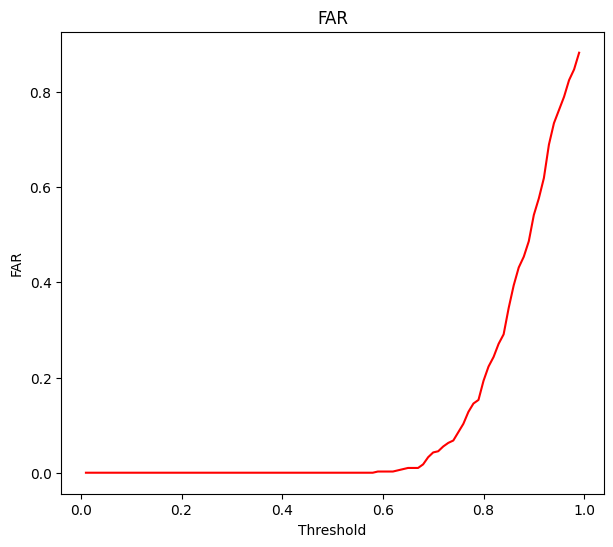

In [38]:
thresholds = [key for key in results.keys()]
far = [results[thresh]['FAR'] for thresh in thresholds]


plt.figure(figsize=(7, 6)) 
plt.plot(thresholds, far, linestyle='-', color='r')
plt.title('FAR')
plt.xlabel('Threshold')
plt.ylabel('FAR')
plt.show()

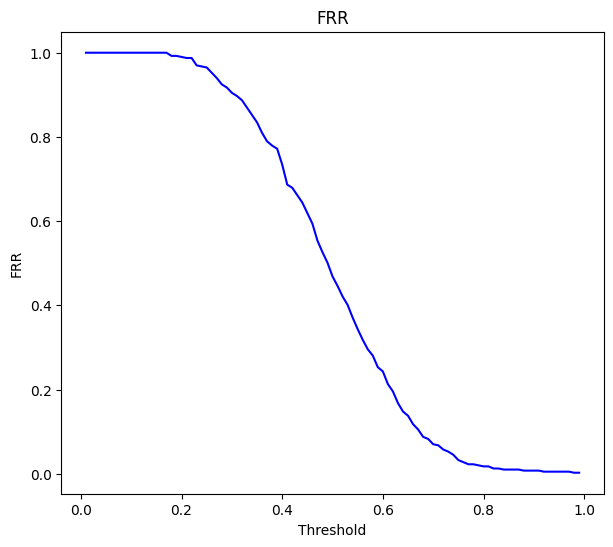

In [39]:
frr = [results[thresh]['FRR'] for thresh in thresholds]
plt.figure(figsize=(7, 6))
plt.plot(thresholds, frr, linestyle='-', color='b')
plt.title('FRR')
plt.xlabel('Threshold')
plt.ylabel('FRR')
plt.show()

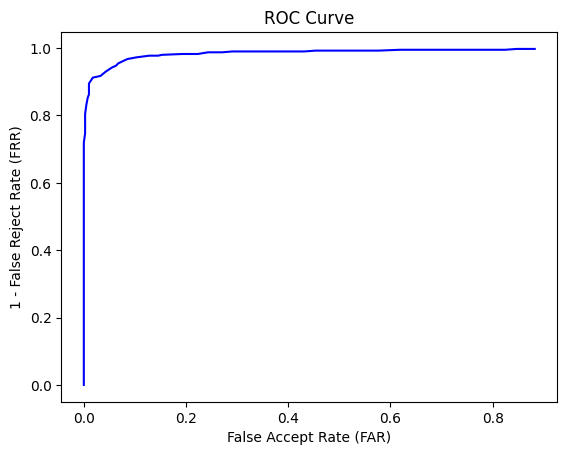

In [40]:
frr1 = [1-results[thresh]['FRR'] for thresh in thresholds]


plt.figure()
plt.plot(far, frr1, linestyle='-', color='b')
plt.title('ROC Curve')
plt.xlabel('False Accept Rate (FAR)')
plt.ylabel('1 - False Reject Rate (FRR)')
plt.show()

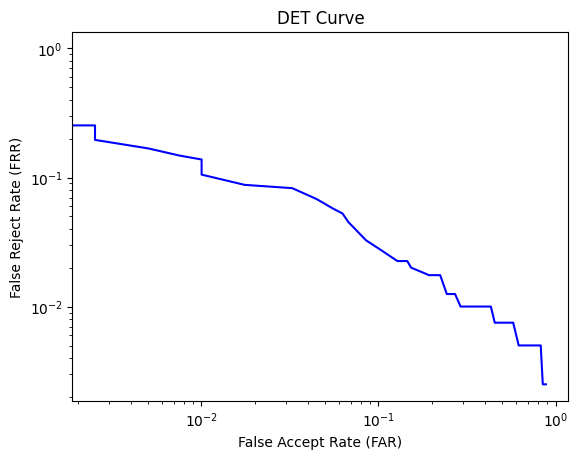

In [41]:
# Extract FAR and FRR values for plotting
fars = [results[thresh]['FAR'] for thresh in thresholds if thresh != 'inf']
frrs = [results[thresh]['FRR'] for thresh in thresholds if thresh != 'inf']

# Since 'inf' can't be plotted, we remove it from the list of thresholds
# Also, we ensure thresholds are sorted because the plotting assumes this order
sorted_indices = np.argsort(thresholds)
fars = np.array(fars)[sorted_indices]
frrs = np.array(frrs)[sorted_indices]

# Plotting the DET curve
plt.figure()
plt.plot(fars, frrs, linestyle='-', color='b')
plt.xscale('log')
plt.yscale('log')
plt.title('DET Curve')
plt.xlabel('False Accept Rate (FAR)')
plt.ylabel('False Reject Rate (FRR)')
plt.show()